In [1]:
import torch
import numpy as np
import pandas as pd
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


from lightning_models import ForecastNextKDays
from torchinfo import summary

In [2]:
model = ForecastNextKDays(data_path = 'Dataset\IKCO1.csv',
                            split = [0.80, 0.10, 0.10],
                            batch_size = 128,
                            learning_rate = 1e-4,
                            weight_decay = 0)



summary(model, input_size = (128, 21, 5))

Layer (type:depth-idx)                   Output Shape              Param #
ForecastNextKDays                        --                        --
├─forecastLSTM: 1-1                      [128, 1]                  --
│    └─LSTM: 2-1                         [128, 21, 128]            465,408
│    └─Linear: 2-2                       [128, 1]                  129
├─MSELoss: 1-2                           --                        --
├─MeanAbsoluteError: 1-3                 --                        --
Total params: 465,537
Trainable params: 465,537
Non-trainable params: 0
Total mult-adds (G): 1.25
Input size (MB): 0.05
Forward/backward pass size (MB): 2.75
Params size (MB): 1.86
Estimated Total Size (MB): 4.67

In [3]:
checkpoint_callback = ModelCheckpoint(dirpath = 'forecast',
                                    filename = "checkpoint.ckpt",
                                    every_n_epochs = 1,
                                    monitor = 'val_loss',
                                    mode = 'min')

early_stop_callback = EarlyStopping(monitor = "val_loss",
                                    min_delta = 0.00,
                                    patience = 15,
                                    verbose = False,
                                    mode = "min")


logger = TensorBoardLogger('forecast-logs/', name = 'forecast', version = 0)

In [4]:
trainer = Trainer(
    default_root_dir = 'forecast-logs/',
    gpus = (1 if torch.cuda.is_available() else 0),
    callbacks = [checkpoint_callback,
                        early_stop_callback],

    auto_lr_find = True,
    auto_scale_batch_size = True,                    
    max_epochs = 200,
    logger = logger)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type              | Params
----------------------------------------------------------
0 | model               | forecastLSTM      | 465 K 
1 | loss                | MSELoss           | 0     
2 | mean_absolute_error | MeanAbsoluteError | 0     
----------------------------------------------------------
465 K     Trainable params
0         Non-trainable params
465 K     Total params
1.862     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch

Epoch 31: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s, loss=0.00487, v_num=0, train_loss=0.0112]


In [5]:
trainer.test(datamodule = model)

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1444: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:412: LightningDeprecationWarning: `LightningDataModule.on_save_checkpoint` was deprecated in v1.6 and will be removed in v1.8. Use `state_dict` instead.
  rank_zero_deprecation(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:417: LightningDeprecationWarning: `LightningDataModule.on_load_checkpoint` was deprecated in v1.6 and will be removed in v1.8. Use `load_state_dict` instead.
  rank_zero_deprecation(
Restoring states from the checkpoint path at C:\Users\Yegyanathan V\Desktop\Python\De

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 19.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           MAE              0.23764201998710632
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'MAE': 0.23764201998710632}]

In [14]:
from utils import create_dataset

model = model.load_from_checkpoint("forecast\checkpoint.ckpt.ckpt")
df = pd.read_csv('Dataset\IKCO1.csv', index_col = [0])

df_X = df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']] 
df_y = df[['<CLOSE>']]

df_X_scaled = model.scaler_X.transform(df_X)


inputs, actuals = create_dataset(df_X_scaled, df_y, 21, 10)

In [15]:
print(inputs.shape, actuals.shape)

(4066, 21, 5) (4066, 1)


In [16]:
inputs = torch.tensor(inputs.astype(np.float32))
inputs

tensor([[[2.0843e-01, 1.7390e-01, 2.1794e-01, 2.0865e-01, 4.3901e-04],
         [2.0865e-01, 1.7462e-01, 2.1783e-01, 2.0843e-01, 3.8199e-04],
         [2.0843e-01, 1.7372e-01, 2.1760e-01, 2.0811e-01, 6.6190e-04],
         ...,
         [2.3911e-01, 2.0054e-01, 2.4992e-01, 2.3976e-01, 1.9753e-03],
         [2.3976e-01, 2.0342e-01, 2.5036e-01, 2.4405e-01, 2.8186e-03],
         [2.4405e-01, 2.1746e-01, 2.5493e-01, 2.6078e-01, 3.7331e-04]],

        [[2.0865e-01, 1.7462e-01, 2.1783e-01, 2.0843e-01, 3.8199e-04],
         [2.0843e-01, 1.7372e-01, 2.1760e-01, 2.0811e-01, 6.6190e-04],
         [2.0811e-01, 1.7813e-01, 2.1772e-01, 2.1390e-01, 3.1825e-04],
         ...,
         [2.3976e-01, 2.0342e-01, 2.5036e-01, 2.4405e-01, 2.8186e-03],
         [2.4405e-01, 2.1746e-01, 2.5493e-01, 2.6078e-01, 3.7331e-04],
         [2.6078e-01, 2.3222e-01, 2.8056e-01, 2.7837e-01, 3.8441e-03]],

        [[2.0843e-01, 1.7372e-01, 2.1760e-01, 2.0811e-01, 6.6190e-04],
         [2.0811e-01, 1.7813e-01, 2.1772e-01,

In [17]:
model.eval()
with torch.no_grad():
    
    output = model(inputs) 

preds = output.squeeze()
preds = np.array(preds) 
preds

array([0.23523585, 0.23643993, 0.23852892, ..., 0.03404427, 0.03252317,
       0.02788311], dtype=float32)

In [18]:
print(preds.shape)

(4066,)


In [19]:
predictions = pd.DataFrame(preds, columns = ['preds'])
predictions[['preds']] = model.scaler_y.inverse_transform(predictions[['preds']])

In [20]:
predictions['actuals'] = actuals
predictions.head(10)

,preds,actuals
0,3047.868652,3598.0
1,3059.093018,3598.0
2,3078.566650,3598.0
3,3106.520508,3598.0
4,3140.389893,3598.0
5,3175.542236,3598.0
6,3207.298096,3598.0
7,3233.510742,3598.0
8,3255.241699,3598.0
9,3274.763428,3576.0


<AxesSubplot:>

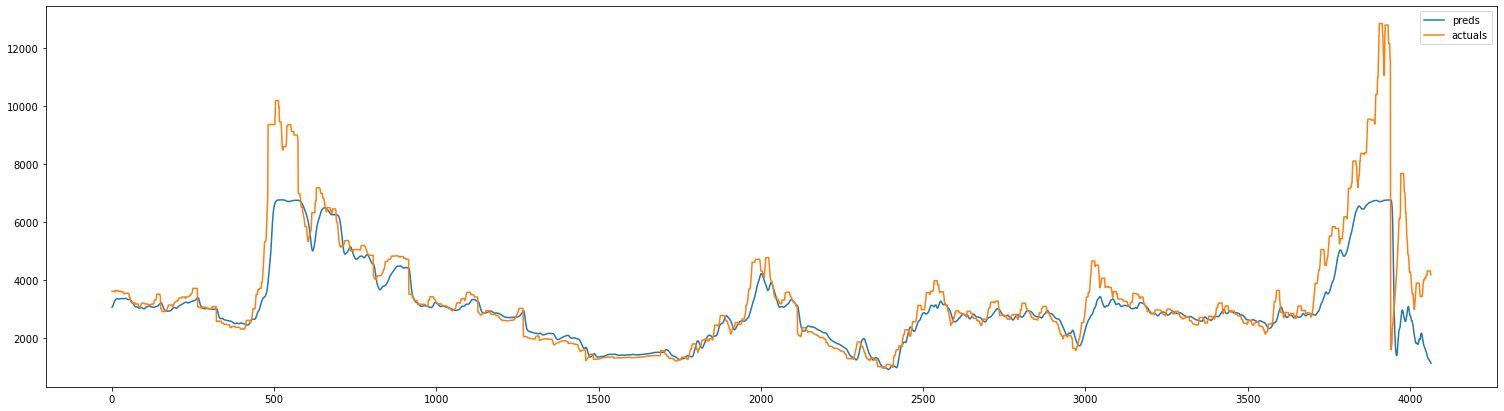

In [30]:
predictions.plot(figsize = (26, 7))